In [21]:
import dask.array as da
import warnings

import dask.array as da
from sklearn.pipeline import Pipeline
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from dask_ml.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas
from toolz.curried import groupby, valmap, pipe, pluck, merge_with, merge
from toolz.curried import map as fmap

from pymks.fmks.data.elastic_fe import solve
from pymks.fmks.data.multiphase import generate

from pymks.fmks.plot import plot_microstructures
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointCorrelation, FlattenTransformer
from dask.distributed import Client, progress
import time


In [22]:
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
da.random.seed(10)
np.random.seed(10)

tmp = [
    generate(shape=(100, 101, 101,101), grain_size=x, volume_fraction=(0.5, 0.2,0.3), chunks=25, percent_variance=0.15)
    for x in [(15, 2,2), (2,2, 15), (7,7, 7), (9, 9,3), (9,9, 9), (2, 2,2)]
]
x_data_gen = da.concatenate(tmp)

In [24]:
x_data_gen

dask.array<concatenate, shape=(600, 101, 101, 101), dtype=int64, chunksize=(25, 101, 101, 101), chunktype=numpy.ndarray>

In [25]:
print(x_data_gen.shape)
print(x_data_gen.chunks)


(600, 101, 101, 101)
((25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25), (101,), (101,), (101,))


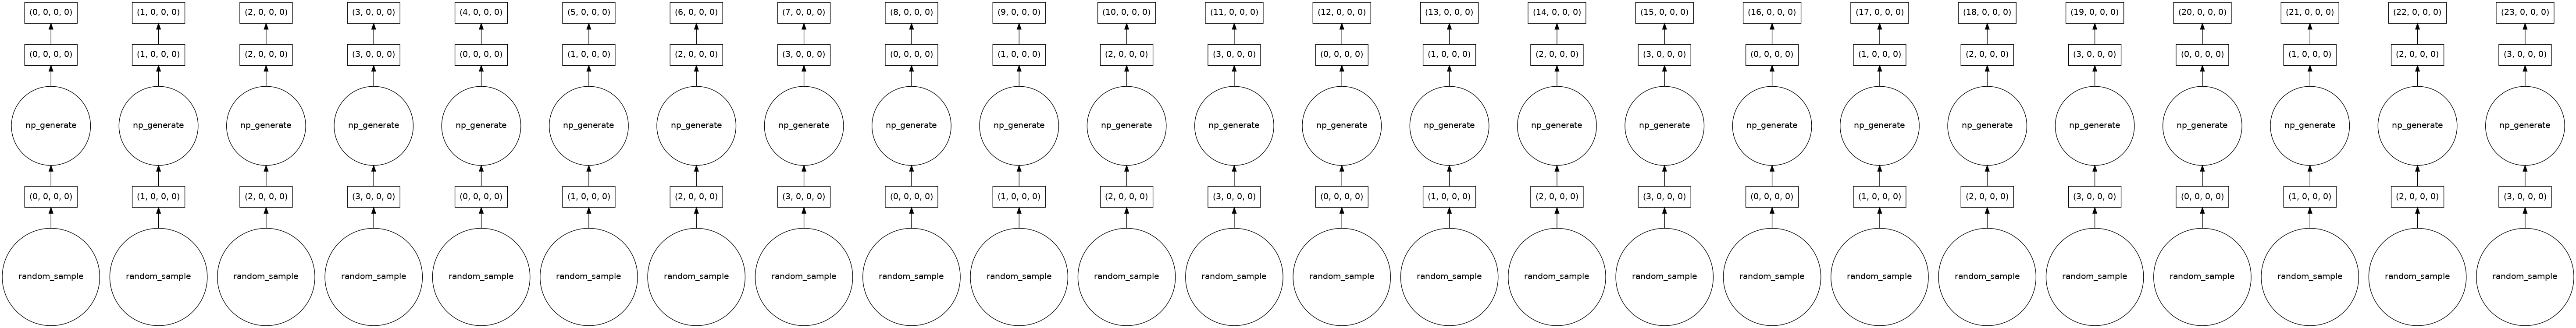

In [26]:
x_data_gen.visualize()

In [27]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41725 Dashboard: http://127.0.0.1:46491/status,Cluster Workers: 4 Cores: 8 Memory: 33.59 GB


In [28]:
# client = Client( threads_per_worker=2,
#                 n_workers=2, memory_limit='8GB')
# client

In [29]:
bl1 = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=15,correlations=[(1,1)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA(n_components=3))])

In [30]:
tic = time.time()
a=bl1.fit(x_data_gen)
toc = time.time()
print(tic-toc)

-57.442631244659424


In [48]:
tic = time.time()
b=bl1.transform(x_data_gen).compute()
toc = time.time()
print(tic-toc)
print(b)

-58.77580714225769
[[-13.88907373  -0.33976408  -0.19826473]
 [-11.71346604  -0.33733315  -0.19920074]
 [ 18.81745128  -0.3199152   -0.17776394]
 ...
 [  0.41182616  -0.38762299   0.0403776 ]
 [ 25.86624688  -0.37164596   0.05094692]
 [-16.82978407  -0.39816748   0.033917  ]]


<IPython.core.display.Javascript object>


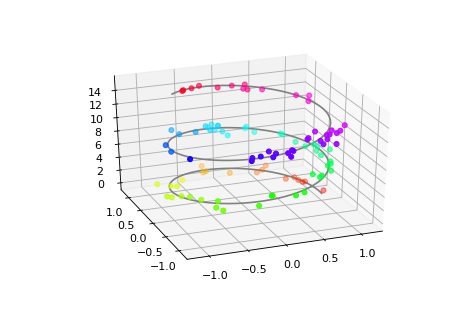

In [45]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# z_line = np.linspace(0, 15, 1000)
# x_line = np.cos(z_line)
# y_line = np.sin(z_line)
# ax.plot3D(x_line, y_line, z_line, 'gray')

z_points = b[:,0]
x_points = b[:,0]
y_points = b[:,0]
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

plt.show()

In [44]:
from mpl_toolkits import mplot3d
%matplotlib notebook

